# Loan Default Prediction — Results Summary

**Aim:**  
To build a predictive model that estimates the probability of a borrower defaulting **before** a loan is issued, using LendingClub historical data.  
Our goal: **maximize default detection (recall) while maintaining reasonable precision**, enabling better credit risk decisions.


## Workflow

We followed a full ML lifecycle:

1. **01_load_data** — Loaded raw LendingClub dataset.
2. **02_data_cleaning** — Kept only features available pre-loan; removed high-NaN columns; preserved `emp_length` NaNs for later handling.
3. **03_feature_engineering** — Converted categorical text into numeric:
   - `term` → 36 / 60 months
   - `emp_length` → numeric scale 0–10
   - `loan_status` → binary target (1=Default, 0=Fully Paid)
   - `credit_history_years` from `earliest_cr_line`
4. **04_EDA** — Identified risk drivers:
   - Higher `int_rate`, lower `FICO`, higher `dti` → more defaults
   - Loan purpose affects risk
5. **05_data_pre_processing** — Split into train/test (80/20 stratified), applied `ColumnTransformer`:
   - Numeric → median impute + scale
   - Ordinal (`grade`) → encoded
   - Nominal → one-hot encode
   - Saved preprocessor, train/test arrays, and feature metadata
6. **06_modelling** — Trained:
   - Logistic Regression (baseline)
   - Random Forest (baseline + tuned via RandomizedSearchCV)
   - Chose **Random Forest tuned** as final model
   - Selected threshold = 0.25 (improves recall)


## Model Performance

### Final Model: Random Forest (Tuned)
- **ROC-AUC (CV)**: 0.713
- **ROC-AUC (Test)**: 0.71
- **PR-AUC (Test)**: 0.45
- **Threshold chosen**: 0.25 (vs default 0.5)

| Metric         | @0.50 threshold | @0.25 threshold |
|----------------|-----------------|-----------------|
| Precision      | 0.69            | 0.55            |
| Recall         | 0.32            | 0.61            |
| F1-Score       | 0.44            | 0.57            |
| Defaults caught (%) | 32%       | 61%             |

> **Interpretation:**  
> Lowering the threshold from 0.50 → 0.25 significantly improves recall (catching more defaults) with a moderate drop in precision. This aligns with credit risk priorities, where missing a default is more costly than flagging a few extra good loans.


## Top Risk Drivers (Feature Importances)

1. `fico_range_high`
2. `int_rate`
3. `dti`
4. `grade`
5. `revol_util`
6. `annual_inc`
7. `credit_history_years`
8. `purpose_credit_card`
9. `purpose_debt_consolidation`

> These align with financial intuition:  
> Borrowers with **lower FICO scores**, **higher interest rates**, and **higher debt-to-income ratios** are more likely to default.


## Business Value

- **Better Risk Assessment:**  
  Model allows pre-loan default probability estimation for each borrower.
  
- **Policy Adjustment:**  
  Lenders can adjust the decision threshold depending on credit risk appetite.

- **Portfolio Optimization:**  
  Higher recall on defaults → fewer bad loans → improved portfolio quality.


**Load model/threshold : evaluate & plot**

In [3]:
# --- Imports ---
from sklearn.metrics import (
    roc_curve, precision_recall_curve, f1_score,
    classification_report, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import joblib, json

# --- Helper Functions ---
def evaluate_at_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

def plot_roc_pr(y_true, y_proba, title_suffix=""):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {title_suffix}')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve {title_suffix}')
    plt.legend()
    plt.show()

def find_best_threshold(y_true, y_proba, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 19)
    scores = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        if metric == "f1":
            s = f1_score(y_true, y_pred)
        elif metric == "youden":
            fpr, tpr, thr = roc_curve(y_true, y_proba)
            idx = (np.abs(thr - t)).argmin()
            s = tpr[idx] - fpr[idx]
        else:
            s = f1_score(y_true, y_pred)
        scores.append((t, s))
    best_t, best_s = max(scores, key=lambda x: x[1])
    return best_t, best_s

Classification report @threshold 0.25
              precision    recall  f1-score   support

           0      0.888     0.624     0.733    215154
           1      0.312     0.684     0.429     53662

    accuracy                          0.636    268816
   macro avg      0.600     0.654     0.581    268816
weighted avg      0.773     0.636     0.672    268816



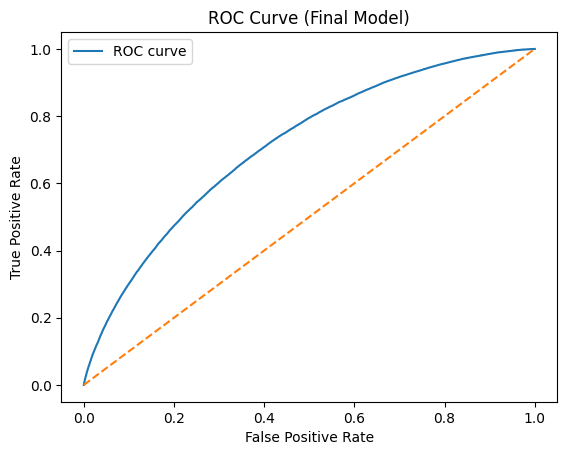

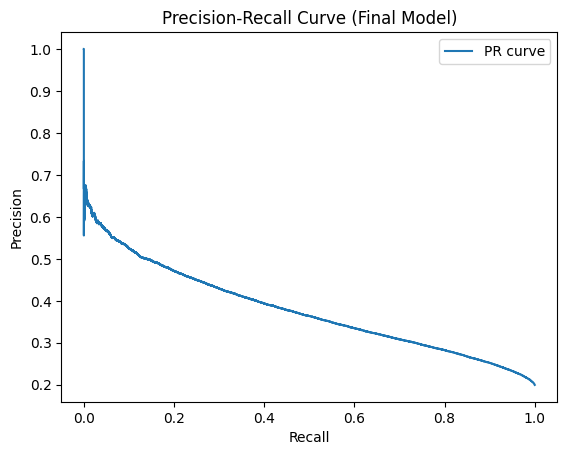

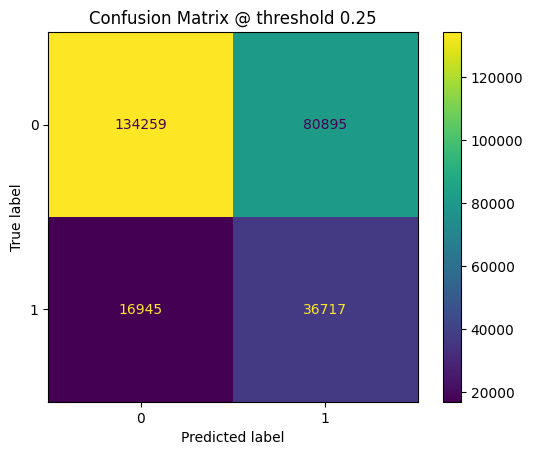

In [7]:
# --- Load Model & Threshold ---
rf_tuned = joblib.load("../models/best_model.joblib")
with open("../models/threshold.json") as f:
    thr = json.load(f)['threshold']

# --- Load Test Data ---
X_test = np.load("../data/processed/X_test.npy")
y_test = np.load("../data/processed/y_test.npy")

# --- Predictions ---
proba = rf_tuned.predict_proba(X_test)[:, 1]
preds = (proba >= thr).astype(int)

# --- Metrics ---
print("Classification report @threshold", thr)
print(classification_report(y_test, preds, digits=3))

# --- Plots ---
plot_roc_pr(y_test, proba, title_suffix="(Final Model)")

# COnfusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.title(f"Confusion Matrix @ threshold {thr}")
plt.show()
